**Imports**

In [1]:
import glob

import mne
from mne.preprocessing import ICA
import os
import re
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
from scipy.stats import skew, kurtosis, entropy, mode
from scipy.signal import stft, welch
import antropy as ant
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skrebate import ReliefF
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, LGBMModel

**Iteriert durch den Ordner und sucht nach allen edf Dateien. Gefundene Dateien werden außerdem Sortiert**

In [2]:
def find_edf(directory):
    paths = []
    pattern = r".*\[\d+\].edf"
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Check if filename matches the pattern
        if re.match(pattern, filename):
            # Construct the full file path
            filepath = os.path.join(directory, filename)
            # Append to the list of paths
            paths.append(filepath)
    
    paths.sort()
    return paths

**Liest einzelne EDF Datei aus. Und speichert gewünschte Kanäle**

In [3]:
def files_preparation(path):
    include = [
        'EEG C4-A1',
        'EEG C3-A2', 
        'EOG ROC-A1', 
        'EOG LOC-A2', 
        'EMG Chin',
        'ECG I', 
        'ECG II', 
        'EEG A1-A2'
    ]

    raw = mne.io.read_raw_edf(path, preload=True, verbose='error', include=include)
    
    raw.set_channel_types(
        mapping={
        'EEG C4-A1': 'eeg',
        'EEG C3-A2': 'eeg',
        'EEG A1-A2': 'eeg',
        'EOG ROC-A1': 'eog',
        'EOG LOC-A2': 'eog',
        'EMG Chin': 'emg',
        'ECG I': 'ecg',
        'ECG II': 'ecg',
        #'RR': 'ecg',
        }
    )
    
    return raw

**Liest die Labels aus der .rml-Datei aus**

In [4]:
def rml_to_annotations(directory, raw_data):
    os.chdir(directory)
    rml = None
    for file in glob.glob("*.rml"):
        rml = file
        break
    with open(rml, 'r') as f:
        rml_data = f.read()
    user_staging = BeautifulSoup(rml_data, 'xml').find("UserStaging").find("NeuroRKStaging")
    start_time = []
    sleep_stage = []
    for stage in user_staging.find_all('Stage'):
        start_time.append(int(stage['Start']))
        sleep_stage.append(stage['Type'])
        
    onset = np.array(start_time)
    description = np.array(sleep_stage)
    raw_duration = raw_data.times[-1] - raw_data.times[0]
    duration = np.diff(np.append(onset, raw_duration))
    return onset, description, duration

**Macht aus der rohen Aufnahme 30 Sekunden Epochen**

In [5]:
tmax = 30 - 1 / 200

# Von MNE bzw von rml extrahierten Bezeichnungen: ['REM', 'Stage1', 'Stage2', 'Stage3', 'Wake']
EVENTS_AASM = {
    "REM": 1,
    "NREM 1": 2,
    "NREM 2": 3,
    "NREM 3": 4,
    "Wake": 5,
}

def data_preparation(directory):
    print("Data for Directory:  ", directory)
    paths = find_edf(directory)
    data_list = []
    for path in paths:
        raw = files_preparation(path)
        data_list.append(raw)
    
    raw_data = mne.concatenate_raws(data_list)
        
    
    #----------------- Preprocessing ---------------------
    # ---> Butterworth Filter 0.5 - 49.5 Hz
    raw_data = raw_data.filter(
        picks='all',
        l_freq=0.5,
        h_freq=49.5,
        method='iir',
        iir_params=dict(order=10, ftype='butter'),
        verbose='error'
    ) 

    #-----------------------------------------------------

    
    onset, description, duration = rml_to_annotations(directory, raw_data)
    annotations = mne.Annotations(onset=onset, description=description, duration=duration)
    annotations.crop(
        annotations[1]['onset'] - 30 * 20, # 30 * 60 = 1200 Ersten 10 Minuten entfernen
        annotations[-2]['onset'] + 30 * 20 # Letzten 10 Minuten entfernen
    )
    raw_data.set_annotations(annotations)
        
    events, _ = mne.events_from_annotations(
        raw_data, 
        chunk_duration=30,
        verbose='error'
    )
    
    epochs = mne.Epochs(
        raw=raw_data,
        events=events,
        event_id=EVENTS_AASM,
        tmin=0.0,
        baseline=None,
        tmax=tmax,
        verbose='error',
        on_missing='warn'
    )
    
    labels = epochs.events[:, 2]
    
    return epochs, labels

**Feature Extraction. Welche Feature extrahiert werden wird in feature_extraction() bestimmt/aufgelistet**

1. Time Domain Feature
2. Frequency Domain Feature
3. Non-Linear Features

##### 1. Time Domain Features

- Mean
- Median
- Mode
- Minimum
- Maximum
- Standard Derivation
- Variance Skewness
- Kurtosis
- Percentile
- Hjorth Parameters
    - Hjorth Mobility
    - Hjorth Complexity
    - Hjorth Activity -> Same as numpy.var(). Calulated earlier in Variance

In [6]:
def mean(epochs):
    data = epochs.get_data(verbose='error')
    mean_features = np.mean(data, axis=2)
    return mean_features

def median(epochs):
    data = epochs.get_data(verbose='error')
    median_features = np.median(data, axis=2)
    return median_features

def mode_feat(epochs):
    data = epochs.get_data(verbose='error')
    mode_features, _ = mode(data, axis=2)
    return mode_features

def minimum(epochs):
    data = epochs.get_data(verbose='error')
    min_values = np.min(data, axis=2)
    return min_values

def maximum(epochs):
    data = epochs.get_data(verbose='error')
    return np.max(data, axis=2)

def standard_derivation(epochs):
    #Extract standard deviation features from a mne.Epochs object.
    data = epochs.get_data(verbose='error')
    std_features = np.std(data, axis=2)
    return std_features

def variance_skewness(epochs):
    #Extract variance features from an mne.Epochs object.
    
    data = epochs.get_data(verbose='error')
    variance_features = np.var(data, axis=2)
    return variance_features

def kurtosis_feat(epochs):
    data = epochs.get_data(verbose='error')
    kurtosis_data = kurtosis(data, axis=2, fisher=False)
    return kurtosis_data

def percentile(epochs, percent = 50):
    data = epochs.get_data(verbose='error')
    percentile_features = np.percentile(data, percent, axis=2)
    return percentile_features

def energy_sis(epochs):
    data = epochs.get_data(verbose='error') 
    n_epochs, n_channels, n_times = data.shape

    energy_array = np.zeros((n_epochs, n_channels))

    for epoch_idx in range(n_epochs):
        for channel_idx in range(n_channels):
            signal = data[epoch_idx, channel_idx, :]

            energy = np.sum(signal ** 2)

            energy_array[epoch_idx, channel_idx] = energy

    return energy_array


def time_domain_features(epochs):
    time_features_methods = [
        # Hier werden die Time Domain Feature berechnet
        mean(epochs),
        median(epochs),
        mode_feat(epochs),
        minimum(epochs),
        maximum(epochs),
        standard_derivation(epochs),
        variance_skewness(epochs),
        kurtosis_feat(epochs),
        percentile(epochs),
        energy_sis(epochs)
        
    ]
    return np.concatenate(time_features_methods, axis=1)

##### 2. Frequency Domain Features

- Relative Spectral Power
- Band Power -> Delta, Theta, Alpha, Beta, Slow wave Frequency Sub-Bands
- 7 Power Ratios

In [7]:
def eeg_power_band(epochs):
    """EEG Power bands """
    
    FREQ_BANDS = {
        "delta": [0, 3.99], #[0.5, 4],
        "theta": [4, 7.99], #[4, 8],
        "alpha": [8, 13],
        #"sigma": [12, 16],
        "slow wave": [0.5, 2.0],
        "beta": [13, 49.5],
    }

    spectrum = epochs.compute_psd(picks="eeg", method='welch', fmin=0.5, fmax=30.0, verbose='error')
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    re = np.concatenate(X, axis=1)
    return re


def frequency_domain_features(epochs):
    frequency_features_methods = [
        eeg_power_band(epochs),
    ]
    return np.concatenate(frequency_features_methods, axis=1)


##### 3. Non-Linear Features

- Zero-Cross-Rate
- Spectral Entropy

In [8]:
def zero_cross_rate(epochs):
    data = epochs.get_data(verbose='error')
    return np.mean(np.diff(np.sign(data), axis=2) != 0, axis=2)

def spectral_entropy(epochs, method='fft', **kwargs):

    data = epochs.get_data(verbose='error')
    sfreq = epochs.info['sfreq']
    n_epochs, n_channels, n_times = data.shape
    
    spec_entropy_array = np.zeros((n_epochs, n_channels))
    
    for epoch_idx in range(n_epochs):
        for channel_idx in range(n_channels):
            single_epoch_data = data[epoch_idx, channel_idx, :]
            se = ant.spectral_entropy(single_epoch_data, method=method, sf=sfreq, **kwargs)
            spec_entropy_array[epoch_idx, channel_idx] = se
    
    return spec_entropy_array

def non_linear_features(epochs):
    nlinear_features_methods = [
        zero_cross_rate(epochs),
        spectral_entropy(epochs)
    ]
    return np.concatenate(nlinear_features_methods, axis=1)

**Feature Funktion**

In [9]:
def feature_extraction(epochs):
    
    features_methods = [
        time_domain_features(epochs),
        frequency_domain_features(epochs),
        non_linear_features(epochs)
    ]
    
    features_methods = np.concatenate(features_methods, axis=1)
    return features_methods

**Sucht nach allen Unterordner, liest diese aus und gibt fertige Epochen aus allen Dateien zurück**

In [10]:
def list_subdirectories(directory):
    return [os.path.join(directory, sub_dir) for sub_dir in os.listdir(directory) if os.path.isdir(os.path.join(directory, sub_dir))]

def process_all_folders(main_directory):
    """Iterates over all subdirectories in the main directory and prepares data."""
    all_epochs = []
    all_labels = []
    
    subdirectories = list_subdirectories(main_directory)
    
    for sub_dir in subdirectories:
        epochs, labels = data_preparation(sub_dir)
        epochs = feature_extraction(epochs)
        all_epochs.append(epochs)
        all_labels.append(labels)
    
    # Combine all data if needed
    combined_epochs = np.concatenate(all_epochs, axis=0) if all_epochs else None
    combined_labels = np.concatenate(all_labels, axis=0) if all_labels else None
    
    return combined_epochs, combined_labels

# Example usage
main_directory = '/Volumes/Jonas_SSD/test'
X, y = process_all_folders(main_directory)

Data for Directory:   /Volumes/Jonas_SSD/test/00000021-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000702-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000042-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000775-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000035-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000398-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000062-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000706-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000043-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000055-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000708-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000060-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000077-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000709-A5BS00755
Data for Directory:   /Volumes/Jonas_SSD/test/00000070-A5BS00755
Data for Directory:   /Vo

In [11]:
X.shape

(129754, 111)

In [12]:
y.shape

(129754,)

**Normalization**

In [13]:
print(f"Before Scaling: {X[222, :10]}") # Selects 10 values of epoch 222 to showcase normalization
X = StandardScaler().fit_transform(X)
print(f"After Scaling:  {X[222, :10]}")

Before Scaling: [ 2.64504821e-08 -1.64480549e-08  6.15684526e-08 -4.74998777e-09
 -1.11762382e-09  2.17014702e-09  1.32438149e-07 -2.54186287e-08
 -1.73766874e-07  5.28585550e-08]
After Scaling:  [ 0.2242799  -0.14475999  0.50272108 -0.03499775 -0.01375852  0.00717116
  0.19499255 -0.06149885 -0.68829066  0.04905104]


**Train/Test Split**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=0.20, stratify=y, random_state=42)

print(f"Originale Anzahl der Instanzen: {X.shape[0]}")
print(f"Reduzierte Anzahl der Instanzen: {X_sample.shape[0]}")

Originale Anzahl der Instanzen: 129754
Reduzierte Anzahl der Instanzen: 25950


**Machine Learning Modell wird trainiert und Kreuz-Validiert**

EEG + ECG -> Random Forest:
- 72,--% -> kein Overfitting mit 15 Features und 15% Sample-Rate
- 73,72% -> 73%(CV) also kein Overfitting mit 25 Features und 20% Sample-Rate
- 74,88% -> 74%(CV) kein Overfitting mit 30 Features und 20% Sample-Rate
- 74,98% -> 74,5%(CV) kein Overfitting - alle Klassen precision f1Score recall 70+ % accuracy - mit 40 Feature und 20% Sample Rate
- 75,76% -> 75%(CV) kein Overfitting - alle Klassen 70+ % - mit 50 Feature und 20% Sample Rate 
- 75,95% -> 75%(CV) kein Overfitting - alle Klassen 70+ % - mit 60 Feature und 20% Sample Rate


EEG + ECG + EOG -> Random Forest:
- 76,48 -> 75,8% (CV) kein OVerfitting - alle Klassen 70+ % - mit 60 Feature und 20% Sample Rate
- 76,01% -> 75,4% (CV) kein Overfitting - alle Klassen 70+ % - mit 45 Feature und 20% Sample Rate
- 76,77% -> 76,3% (CV) kein Overfitting - alle Klassen 71+ % - mit 80 Feature und 20% Sample Rate

**Feature importance with ReliefF**

Created distance array in 36.739124059677124 seconds.
Feature scoring under way ...
Completed scoring in 2276.3759458065033 seconds.
Selected positive features indices: [ 81  80  96  95  93  94  82  92  90  38  89  70  14  97  87  85 104  91
 102 103  84  83  86 106  98 105  88  99  71  15 100  39  46 110  30  22
 109  13  69 107  35  36  40 108  34  17  25  31  23  27  19  32  33  41
  44  24  16 101  18  26  37  28  20  42  43  10  66  47  21  29  78  54
  45  67  11   8  64   9  65  62  61  48  72  12  68  63  55  79  60  76
  52  75  51  74  50  73  49  53  77   3  59  58   2   4  57   0  56   6
   5   1   7]
Von 111 berechneten Features werden 111 verwendet.


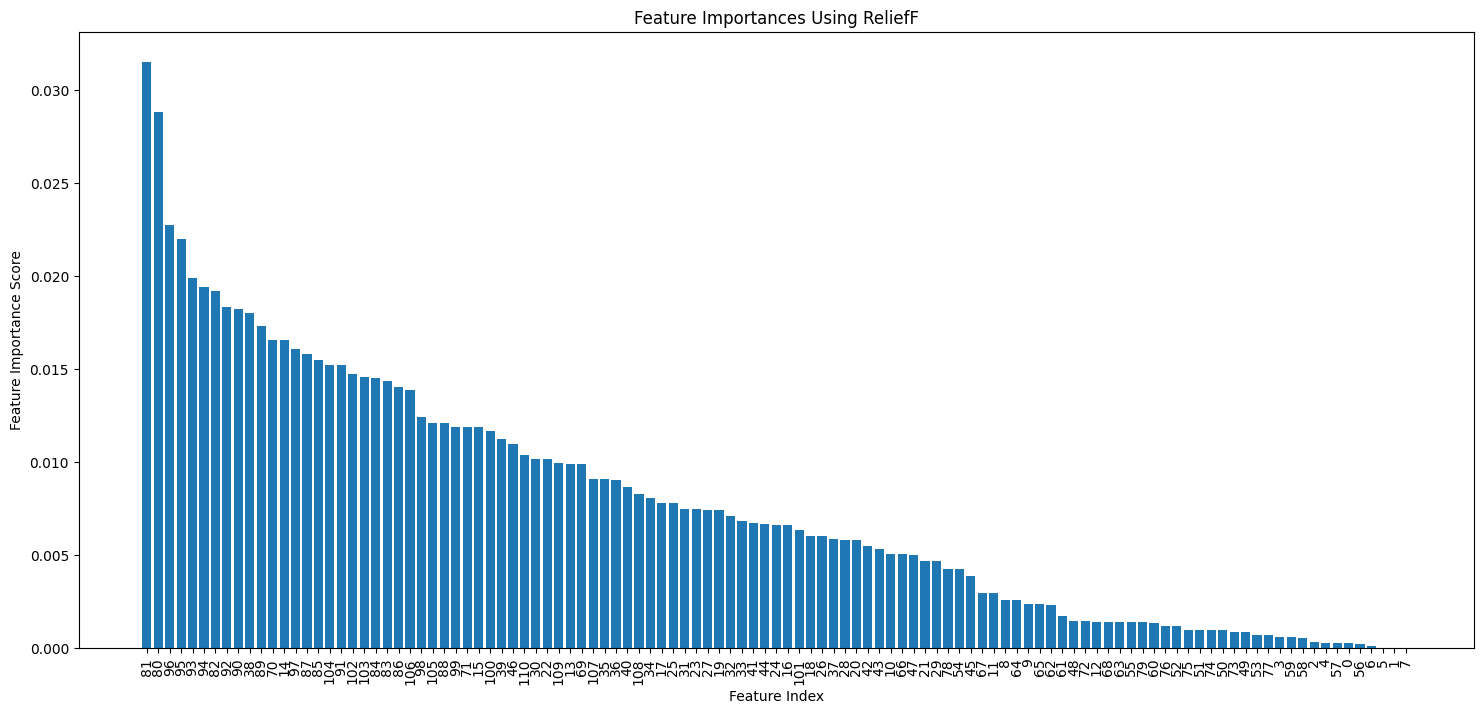

In [16]:
relieff = ReliefF(n_neighbors=100, n_features_to_select=None, verbose=True, n_jobs=-1)
relieff.fit(X_sample, y_sample)

feature_scores = relieff.feature_importances_
sorted_indices = np.argsort(feature_scores)[::-1]
sorted_scores = feature_scores[sorted_indices]

positive_indices = sorted_indices[sorted_scores > 0]

X_train = X_train[:, positive_indices]
X_test = X_test[:, positive_indices]

print(f"Selected positive features indices: {positive_indices}")
print(f"Von {X.shape[1]} berechneten Features werden {X_train.shape[1]} verwendet.")

# Plot all feature importances
plt.figure(figsize=(18, 8))
plt.bar(range(len(sorted_scores)), sorted_scores, tick_label=sorted_indices)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importances Using ReliefF')
plt.xticks(rotation=90)
plt.show()

**Training**

In [19]:
pipe = make_pipeline(
    SVC(C=10, decision_function_shape='ovr', gamma='scale'),
    #RandomForestClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=1, n_jobs=-1),
    #KNeighborsClassifier(n_neighbors=15, weights="uniform", metric='manhattan', n_jobs=-1),
    #LGBMClassifier(n_estimators=500, learning_rate=0.2, verbose=0, n_jobs=-1),
)

# Grid Search
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularisierungsparameter
    'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernelkoeffizient
    'svc__decision_function_shape': ['ovr', 'ovo']  # Multiklassenstrategie
}
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
#grid_search.fit(X_train, y_train)
#print(f"Best parameters from Grid Search: {grid_search.best_params_}")
#print(f"Best cross-validation score from Grid Search: {grid_search.best_score_}")


# Cross Validation
#best_model = grid_search.best_estimator_
cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
print(f"Standard deviation of cross-validation score: {cv_scores.std()}")

pipe.fit(X_train, y_train)

Cross-validation scores: [0.76821926 0.7691826  0.76797842 0.76676301 0.77235067]
Mean cross-validation score: 0.7688987920974919
Standard deviation of cross-validation score: 0.0018903160003905608


Pipeline(steps=[('svc', SVC(C=10))])

**Evaluation of the test results**

In [20]:
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 77.50%


In [21]:
print(classification_report(y_test, y_pred,target_names=EVENTS_AASM.keys()))

              precision    recall  f1-score   support

         REM       0.87      0.83      0.85      3243
      NREM 1       0.74      0.77      0.76      8372
      NREM 2       0.70      0.70      0.70      6090
      NREM 3       0.81      0.78      0.79      3968
        Wake       0.84      0.84      0.84      4278

    accuracy                           0.77     25951
   macro avg       0.79      0.78      0.79     25951
weighted avg       0.78      0.77      0.78     25951



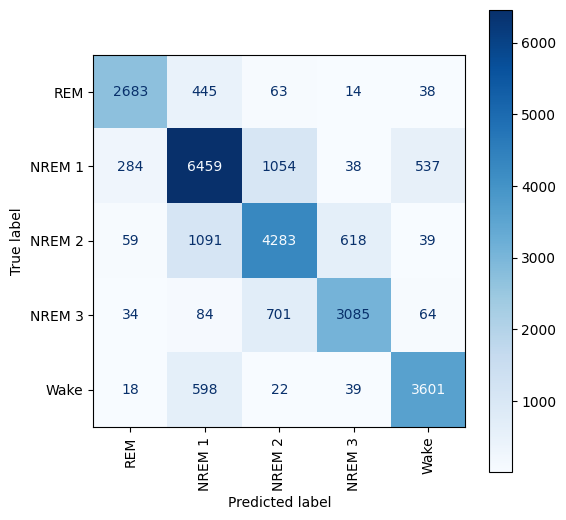

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EVENTS_AASM.keys())
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues,ax=ax, values_format='d', xticks_rotation=90)
ax.grid(False)
plt.show()

**Speichert Modell**

In [ ]:
#dump(pipe, "/RF_features_classifier.joblib")